In [1]:
import pcraster as pcr
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

In [2]:
param_file_name = 'chanbw'
# param_file_name = ''
calibr_param_name = 'ChanBottomWMult'
# calibr_param_name = 'PowerPrefFlow'
template = '/ec/vol/efas/static_data/5.0/ldd.nc'
suite_path = '/ec/fws4/sb/project/CEMS_Floods/calibrations/mct_calib_test_cc2/'

In [3]:
template = xr.open_dataset(template)*0
var_name = list(template.data_vars)
var_name = [i for i in var_name if len(template[i].shape)==2]

/usr/local/apps/python3/3.11.8-01/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
var_name = {i: param_file_name for i in var_name}
template = template.rename(var_name)[param_file_name]
template = template.where(template!=0)

In [5]:
def pcr_setclone_aux(input_nc):
    'Get rows and cols number from the reference nc, for creating the clone needed for the pcraster'
    x_checks = ['lon', 'x', 'rlon']
    y_checks = ['lat', 'y', 'rlat']
    x_proj = set(list(input_nc.coords)) & set(x_checks)
    y_proj = set(list(input_nc.coords)) & set(y_checks)

    if len(x_proj)!=1 or len(y_proj)!=1:
        print('Input dataset coords names for lat/lon are not as expected.')
        print(f'The available coords are: {list(input_nc.coords)}')
        print(f'The checked names are {y_checks} and {x_checks} for lat and lon respectively.')
        exit(1)
    
    x_proj = list(x_proj)[0]
    y_proj = list(y_proj)[0]
    
    rows, cols = len(input_nc[y_proj]), len(input_nc[x_proj])
    return rows, cols

In [6]:
def get_calibrated_parameters(catch_ID):
    'Get statistics about too large river wdiths over the pixel width, after calibrating the associated parameter'
    
    # read default values of the variable of interest
    default_var = xr.open_dataset(f'/ec/fws4/sb/project/CEMS_Floods/calibrations/mct_calib_test_cc2/outputs/catchments/{catch_ID}/maps/{param_file_name}.nc')['Band1']
    
    # calibrated parameters
    calibrated_params_all = f'{suite_path}/outputs/catchments/{catch_ID}/pareto_front.csv'
    
    # read calibration parameters
    if os.path.exists(calibrated_params_all):
        calibrated_params_all = pd.read_csv(calibrated_params_all, index_col=0).T.iloc[2:]
        calibrated_params_all.index = [i.replace(f"param_{j:02d}_", "") for j, i in enumerate(calibrated_params_all.index)]
        calibrated_params = calibrated_params_all.loc[calibr_param_name].values
    else:
        print(f'No calibration parameter available for catchment ID {catch_ID}, default values are used.')
        calibrated_params = 1

    calibrated_var = default_var*calibrated_params
    calibrated_var.name = param_file_name

    # define clone for pcraster, otherwise it gets any clone available which can be wrong
    rows, cols = pcr_setclone_aux(calibrated_var)
    pcr.setclone(rows, cols, 1, 0, 0)
    
    # get masked area for each catchment
    maskmap = pcr.readmap(f'/ec/fws4/sb/project/CEMS_Floods/calibrations/mct_calib_test_cc2/outputs/catchments/{catch_ID}/maps/masksmall.map')
    maskmap = pcr.pcr2numpy(maskmap, 0)

    calibrated_var = calibrated_var.where(maskmap)

    # change coordinates so they are identical with the ones from the template (precision errors are possible)
    min_lon_id = np.argmin(np.abs(template.lon.values-calibrated_var.lon.values[0]))
    max_lon_id = np.argmin(np.abs(template.lon.values-calibrated_var.lon.values[-1]))
    
    min_lat_id = np.argmin(np.abs(template.lat.values-calibrated_var.lat.values[0]))
    max_lat_id = np.argmin(np.abs(template.lat.values-calibrated_var.lat.values[-1]))
    
    new_lats = template.lat.values[min_lat_id:max_lat_id+1]
    new_lons = template.lon.values[min_lon_id:max_lon_id+1]
    
    calibrated_var = calibrated_var.assign_coords(lat=new_lats, lon=new_lons)
    
    return calibrated_var

In [7]:
catchments = os.listdir(f'{suite_path}/outputs/catchments/')
catchments = [i for i in catchments if os.path.exists(f'{suite_path}/outputs/catchments/{i}/maps')]
print(f'Total number of catchments to be analysed: {len(catchments)}')

Total number of catchments to be analysed: 634


In [8]:
final_data = template.copy(deep=True)
not_null = []
for i_catch in tqdm(catchments[:]):
    i_data = get_calibrated_parameters(i_catch)
    i_data_full = i_data.reindex(lat=template.lat, lon=template.lon)
    final_data = xr.where(i_data_full.notnull(), i_data_full, final_data)

  8%|▊         | 48/634 [00:16<03:48,  2.57it/s]

No calibration parameter available for catchment ID 1465, default values are used.


 24%|██▎       | 150/634 [00:54<03:09,  2.55it/s]

No calibration parameter available for catchment ID 2782, default values are used.


 32%|███▏      | 204/634 [01:14<02:26,  2.94it/s]

No calibration parameter available for catchment ID 328, default values are used.


 95%|█████████▌| 603/634 [03:37<00:10,  2.83it/s]

No calibration parameter available for catchment ID 2805, default values are used.


100%|██████████| 634/634 [03:48<00:00,  2.77it/s]


In [9]:
final_data.to_netcdf('/home/ecm8227//Repositories/lisflood-utilities/src/lisfloodutilities/chanbw.nc')

In [9]:
final_data = xr.open_dataset('/home/ecm8227//Repositories/lisflood-utilities/src/lisfloodutilities/chanbw.nc')
LD = xr.open_dataset('/home/ecm8227//Repositories/lisflood-utilities/src/lisfloodutilities/ldd.nc')
x_proj = 'lon'
y_proj = 'lat'

In [10]:
old_name = [i for i in list(LD.data_vars) if sorted(LD[i].dims)==sorted([x_proj, y_proj])]
LD = LD.rename({old_name[0]: "ldd"})['ldd']  # only 1 variable complies with above if

# sometimes the masked value is flagged not with NaN (e.g., with cutmaps it was flagged with 0)
# pcr.Ldd takes only integer values 1-9, so any other value needs to be masked
LD = LD.fillna(-1)  # fill NaN so it can be converted to integer with no issues
LD = LD.astype('int')
LD = LD.where((LD>0) & (LD<10)).fillna(-1)

In [11]:
# convert the xarray to pcraster
LD = LD.transpose(y_proj, x_proj)  # make sure dims order is as pcraster needs

rows, cols = pcr_setclone_aux(LD)
pcr.setclone(rows, cols, 1, 0, 0)

ldd_pcr = pcr.numpy2pcr(pcr.Ldd, LD.values, -1)  # missing values in the np are flagged as -1

# repair the ldd; needed in case ldd is created from cutmaps, so outlet is not flagged with 5 (pit) 
ldd_pcr = pcr.lddrepair(ldd_pcr)
LD

<xarray.DataArray 'ldd' (lat: 2970, lon: 4530)> Size: 108MB
array([[ 5.,  3.,  5., ..., -1., -1., -1.],
       [ 6.,  6.,  6., ..., -1., -1., -1.],
       [ 2.,  2.,  4., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ...,  9.,  2.,  8.],
       [-1., -1., -1., ...,  9.,  6.,  5.],
       [-1., -1., -1., ...,  9.,  8.,  8.]])
Coordinates:
  * lon      (lon) float64 36kB -25.24 -25.23 -25.21 ... 50.21 50.22 50.24
  * lat      (lat) float64 24kB 72.24 72.22 72.21 72.19 ... 22.79 22.77 22.76
Attributes:
    long_name:     GDAL Band Number 1
    grid_mapping:  crs

In [12]:
lat_extended = np.insert(LD.lat.values, 0, LD.lat.values[0]+LD.lat.values[0]-LD.lat.values[1])
lat_extended = np.insert(lat_extended, len(lat_extended), LD.lat.values[-1]+LD.lat.values[-1]-LD.lat.values[-2])

lon_extended = np.insert(LD.lon.values, 0, LD.lon.values[0]+LD.lon.values[0]-LD.lon.values[1])
lon_extended = np.insert(lon_extended, len(lon_extended), LD.lon.values[-1]+LD.lon.values[-1]-LD.lon.values[-2])

LD_extended = LD.reindex(lat=lat_extended, lon=lon_extended).fillna(5)

In [12]:
profile_mask_pcr = LD.fillna(0)*0

# profile_mask_pcr[1510, 2111] = 1
profile_mask_pcr[1510, 1400] = 1
profile_mask_pcr = profile_mask_pcr.astype('int')

In [13]:
profile_mask_pcr = pcr.numpy2pcr(pcr.Boolean, profile_mask_pcr.values, -1)  # convert to Boolean with no NaN (-1 is not possible)
profile_mask_pcr = pcr.path(ldd_pcr, profile_mask_pcr)  # get the actual paths

In [15]:
profile_mask_np = pcr.pcr2numpy(profile_mask_pcr, 0)
ProfPath = LD.fillna(0)*0+profile_mask_np
ProfPath = ProfPath.where(ProfPath==1)
# ProfPath = ProfPath.reindex(lat=lat_extended, lon=lon_extended)
ProfPath.name = 'Profile'
ProfPath.sum()

<xarray.DataArray 'Profile' ()> Size: 8B
array(38.)

In [16]:
lats_used = ProfPath.sum('lon').where(ProfPath.sum('lon')!=0).dropna('lat')
lat_index_start = int(np.where(ProfPath.lat.values==lats_used.lat.values[0])[0][0]-1)
lat_index_stop = int(np.where(ProfPath.lat.values==lats_used.lat.values[-1])[0][0]+2)

lons_used = ProfPath.sum('lat').where(ProfPath.sum('lat')!=0).dropna('lon')
lon_index_start = int(np.where(ProfPath.lon.values==lons_used.lon.values[0])[0][0]-1)
lon_index_stop = int(np.where(ProfPath.lon.values==lons_used.lon.values[-1])[0][0]+2)

<xarray.DataArray 'Profile' (lat: 14, lon: 21)> Size: 2kB
array([[nan, nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1., nan, nan, nan, nan, nan, nan],
       [ 1.,  1.,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan,  1.,  1.,  1.,  1., nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan,  1., nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan,  1., nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan,  1.],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan,  1.,  1.],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan,  1., nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan,  1.,  1.],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan,  1.],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan,  1.],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan,  1., nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan,  1.,  1.,  1.,  1., nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan,  1., nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan,  1.,  1., nan, nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 168B -2.158 -2.142 -2.125 ... -1.858 -1.842 -1.825
  * lat      (lat) float64 112B 47.29 47.27 47.26 47.24 ... 47.11 47.09 47.08

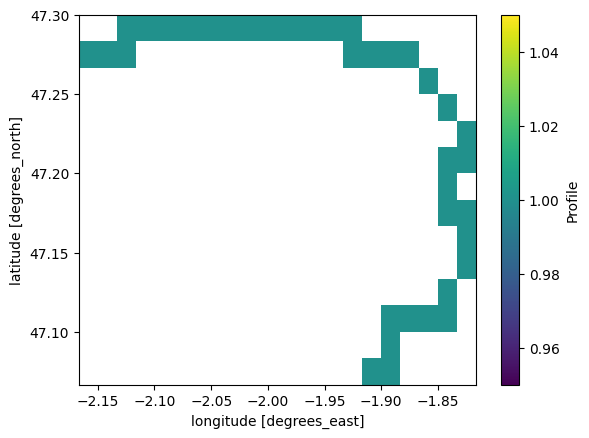

In [18]:
ProfPath_short = ProfPath#.isel(lat=slice(lat_index_start, lat_index_stop), lon=slice(lon_index_start, lon_index_stop)).fillna(0)
# ProfPath_short = ProfPath.isel(lat=ProfPath.sum('lon')!=0, lon=ProfPath.sum('lat')!=0)
ProfPath_short = ProfPath.isel(lat=ProfPath.sum('lon')!=0, lon=ProfPath.sum('lat')!=0)
ProfPath_short.plot()
ProfPath_short

In [19]:
# define clone for pcraster, otherwise it gets any clone available which can be wrong
rows, cols = pcr_setclone_aux(ProfPath_short)
pcr.setclone(rows, cols, 1, 0, 0)

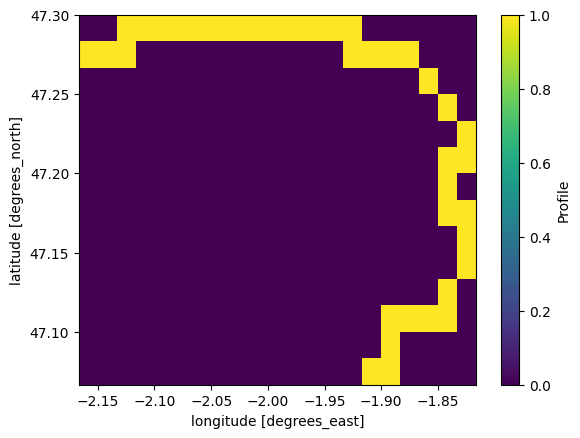

In [20]:
rivers_mask_pcr = pcr.numpy2pcr(pcr.Scalar, ProfPath_short.values, 0)
(ProfPath_short.fillna(0)*0+pcr.pcr2numpy(rivers_mask_pcr, 0)).plot()

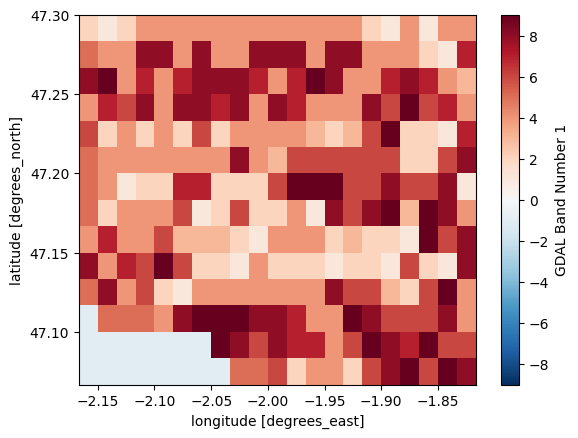

In [22]:
ldd_short_pcr = LD.sel(lat=ProfPath_short.lat.values, lon=ProfPath_short.lon.values)
ldd_short_pcr.plot()
ldd_short_pcr = pcr.numpy2pcr(pcr.Ldd, ldd_short_pcr.values, -1)

In [23]:
# downstream_cells_pcr = rivers_mask_pcr
# (ProfPath_short.fillna(0)*0+pcr.pcr2numpy(downstream_cells_pcr, 0)).where((ProfPath_short.fillna(0)*0+pcr.pcr2numpy(downstream_cells_pcr, 0))!=0).plot()

In [24]:
# downstream_cells_pcr = pcr.downstream(ldd_short_pcr, downstream_cells_pcr)
# (ProfPath_short.fillna(0)*0+pcr.pcr2numpy(downstream_cells_pcr, 0)).where((ProfPath_short.fillna(0)*0+pcr.pcr2numpy(downstream_cells_pcr, 0))!=0).plot()

In [25]:
# set the initial value of the 'downstream' pixels 
# downstream_cells_pcr = pcr.numpy2pcr(pcr.Scalar, pcr.pcr2numpy(profile_mask_pcr, 0), 0)
# sum_rivers_pcr = pcr.numpy2pcr(pcr.Scalar, pcr.pcr2numpy(profile_mask_pcr, 0), 0)

downstream_cells_pcr = rivers_mask_pcr
sum_rivers_pcr = rivers_mask_pcr

downstream_actual_mask_pcr = pcr.downstreamdist(ldd_short_pcr)
downstream_actual_mask_pcr = pcr.ifthenelse(downstream_actual_mask_pcr == 0, pcr.boolean(0), pcr.boolean(1))
downstream_actual_mask_pcr = pcr.scalar(downstream_actual_mask_pcr)

# Loop nloops times and use downstream function to find out if each cell has nloop MCT cells downstream
# Downstream function gives the value in the downstream pixel in a map:
# here it gives 1 if the downstream pixel is Muskingum, zero otherwise.
# The loop is used to count how many pixels are MCT downstream, as at each loop we move the values 1 pixel upstream
# At the end of the loop, each element of the array has the number of downstream MCT pixels for that pixel
for loops in tqdm(range(int(ProfPath_short.sum()))):
# for loops in tqdm(range(1)):
    # get the value on the downstream cell and put it in a mask
    downstream_cells_pcr = pcr.downstream(ldd_short_pcr, downstream_cells_pcr)
    downstream_cells_pcr = downstream_cells_pcr*downstream_actual_mask_pcr
    sum_rivers_pcr = sum_rivers_pcr + downstream_cells_pcr

100%|██████████| 38/38 [00:00<00:00, 20088.68it/s]


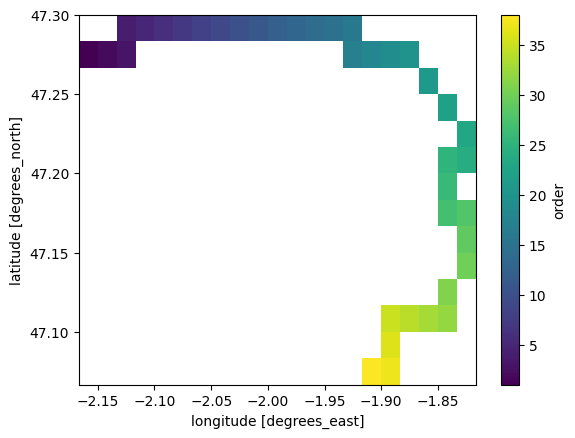

In [33]:
sum_rivers = (ProfPath_short.fillna(0)*0+pcr.pcr2numpy(sum_rivers_pcr, 0))
sum_rivers.name = 'order'
sum_rivers.where(sum_rivers!=0).plot()

In [34]:
all_data = xr.merge([final_data, LD, ProfPath, sum_rivers])

In [37]:
all_data_df = all_data.to_dataframe().reset_index()
all_data_df = all_data_df[~all_data_df.Profile.isna()]
all_data_df = all_data_df.sort_values('order')
all_data_df

,lat,lon,chanbw,ldd,Profile,order
6665015,47.275000,-2.158333,NaN,5.0,1.0,1.0
6665016,47.275000,-2.141667,NaN,4.0,1.0,2.0
6665017,47.275000,-2.125000,NaN,4.0,1.0,3.0
6669547,47.291667,-2.125000,NaN,2.0,1.0,4.0
6669548,47.291667,-2.108333,NaN,4.0,1.0,5.0
6669549,47.291667,-2.091667,NaN,4.0,1.0,6.0
6669550,47.291667,-2.075000,NaN,4.0,1.0,7.0
6669551,47.291667,-2.058333,NaN,4.0,1.0,8.0
6669552,47.291667,-2.041667,NaN,4.0,1.0,9.0
6669553,47.291667,-2.025000,NaN,4.0,1.0,10.0


,lat,lon,chanbw,ldd,Profile,order
6610670,47.075000,-1.908333,NaN,6.0,1.0,38.0
6610671,47.075000,-1.891667,NaN,8.0,1.0,37.0
6615201,47.091667,-1.891667,NaN,8.0,1.0,36.0
6619731,47.108333,-1.891667,NaN,6.0,1.0,35.0
6619732,47.108333,-1.875000,NaN,6.0,1.0,34.0
6619733,47.108333,-1.858333,NaN,6.0,1.0,33.0
6619734,47.108333,-1.841667,NaN,8.0,1.0,32.0
6624264,47.125000,-1.841667,NaN,9.0,1.0,31.0
6628795,47.141667,-1.825000,NaN,8.0,1.0,30.0
6633325,47.158333,-1.825000,NaN,8.0,1.0,29.0


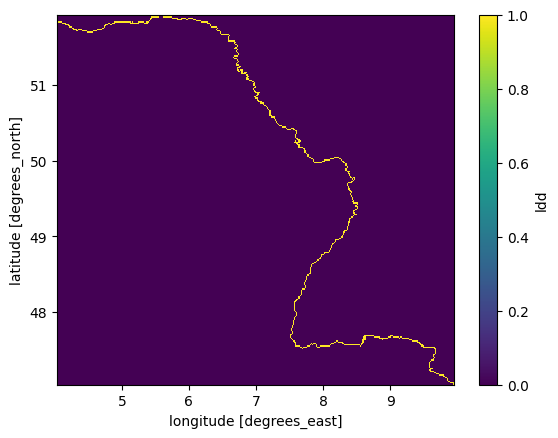

In [21]:
ProfPath.isel(lon=ProfPath.sum('lat')!=0, lat=ProfPath.sum('lon')!=0).plot()

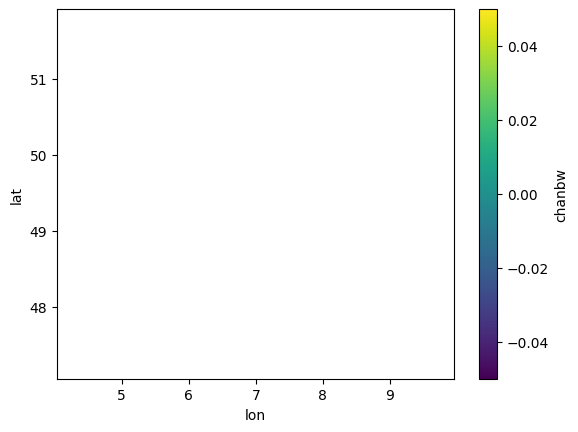

In [108]:
final_data.where(MCT==1).isel(lon=MCT.sum('lat')!=0, lat=MCT.sum('lon')!=0).plot()